# Map the CHM vrt in the domain of summarization

#### Workflow steps: 
1.  `cavm_buffer_above_shrubs.ipynb` --> creates the AOI needed for mosaic
2.  `mosaic_chm_dinvo3.ipynb` --> creates a tiles mosaic of CHM data with masking within AOI
3.  `summarize_chm_dinov3_create.ipynb` --> computes height class summary table
4.  `summarize_chm_dinov3_plot.ipynb` --> uses height class smry to plot bar/donut plot
5.  `map_chm_dinov3.ipynb` --> map corresponding to data plotted from summary

Paul Montesano  
Feb 2026

In [3]:
library(tidyverse)
library(sf)
library(ggspatial)
library(terra)
library(patchwork)
library(RColorBrewer)
library(viridis)
library(ggrepel)

library(patchwork)
library(scales)
library(data.table)

Warning message:
“package ‘tidyverse’ was built under R version 4.4.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘tibble’ was built under R version 4.4.3”
Warning message:
“package ‘tidyr’ was built under R version 4.4.3”
Warning message:
“package ‘readr’ was built under R version 4.4.3”
Warning message:
“package ‘purrr’ was built under R version 4.4.3”
Warning message:
“package ‘dplyr’ was built under R version 4.4.3”
Warning message:
“package ‘stringr’ was built under R version 4.4.3”
Warning message:
“package ‘forcats’ was built under R version 4.4.3”
Warning message:
“package ‘lubridate’ was built under R version 4.4.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.2.0     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.2     ✔ tibble    3.3.1
✔ lubridate 1.9.5     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ──────────────────────────────────────

In [4]:
# library(rnaturalearth)
# library(rnaturalearthdata)

In [5]:
source('~/code/3dsi/boreal_map_functions.R')

Warning message:
“package ‘fs’ was built under R version 4.4.3”


[1] "ADAPT, EXPLORE"
[1] "ADAPT, EXPLORE"


Warning message:
“package ‘gridExtra’ was built under R version 4.4.3”


In [6]:
CRS_LON=-140

In [7]:
crs_canalb = paste0('+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=', CRS_LON,' +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs')

In [8]:
#disp_win_wgs84 <- st_sfc(st_point(c(-165, 52)), st_point(c(-130, 72)), crs = 4326)
disp_win_wgs84 <- st_sfc(st_point(c(-165, 52)), st_point(c(-130, 72)), crs = 4326)
disp_win_wgs84

POINT (-165 52)

POINT (-130 72)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



Geometry set for 2 features 
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -165 ymin: 52 xmax: -130 ymax: 72
Geodetic CRS:  WGS 84

In [9]:
disp_win_trans <- st_transform(disp_win_wgs84, crs = crs_canalb)
disp_win_coord <- st_coordinates(disp_win_trans)

In [81]:
theme_custom = list(
      theme_minimal(),
          annotation_scale(location = "bl", style="ticks") 
          #, annotation_north_arrow(location = "tl", which_north = "true", style=north_arrow_minimal())
    )

do_map_above_boreal_modified <- function(ABOVE_DOMAIN=FALSE){
  
  #boreal = st_read(wwf_circ_dis_fn) %>% st_transform(crs = crs_canalb)
  #above_domain = st_read(above_domain_fn) %>% st_transform(crs = crs_canalb)
  #world <- ne_countries(scale = "medium", returnclass = "sf")
  world = st_read('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/paper_figs/world_ne_countries_medium.gpkg')  
  
  map = ggplot() + 
    
    geom_sf(data = st_as_sf(world) %>% filter(subregion == "Northern America") , size=0.1)+ 
    #geom_sf(data = boreal, color=NA, fill="grey70") +
    geom_sf(data = st_as_sf(world) %>% filter(subregion == "Northern America"), fill=NA, size=0.1 )
  
  if(ABOVE_DOMAIN){
    map = map +
      geom_sf(data = above_domain, fill=NA, linetype = "dotted")
  }
  
  return(map)
}

GET_CUSTOM_DINOv2_ALASKA_MAP <- function(
                                    crs_wgs84 = "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +no_defs",
                                    crs_canalb = '+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'
                                    ){
    # https://www.r-bloggers.com/2019/04/zooming-in-on-maps-with-sf-and-ggplot2/
    disp_win_wgs84 <- st_sfc(st_point(c(-145, 35)), st_point(c(-40, 75)), crs = 4326)
    disp_win_trans <- st_transform(disp_win_wgs84, crs = crs_canalb)
    disp_win_coord <- st_coordinates(disp_win_trans)

    txt_wgs84 <- st_sfc(st_point(c(-132, 63.5)), st_point(c(-120, 58)), st_point(c(-98, 58)), crs = 4326) #-121.5, 52.75
    txt_trans <- st_transform(txt_wgs84, crs = crs_canalb)
    txt_coord <- st_coordinates(txt_trans)

    add_theme_custom = list(
            theme_bw(),
            theme(legend.position = c(0.9 ,0.9), 
              legend.text=element_text(size=rel(1)), 
              legend.background = element_blank(),
              legend.box.background = element_rect(colour = "black"),
              axis.title.x = element_blank(), 
              axis.title.y = element_blank(),
              axis.text = element_text(size = 12),
              axis.text.y = element_text(angle=90, hjust = 0.5)
              )
      )

    custom_map_above = list(
        coord_sf(xlim = disp_win_coord[,'X'], ylim = disp_win_coord[,'Y'], crs = crs_canalb, expand = F),
        #annotation_scale(location = "bl", width_hint = 0.15) ,
        #annotate(geom = "text", x = txt_coord[,'X'], y = txt_coord[,'Y'], label = c("B o r e a l","ABoVE\ndomain","ABoVE\nextended\ndomain"), fontface = c("bold.italic", "italic", "italic"), color = c("grey60","black","black"), size = c(4,3,2)) ,
        add_theme_custom
    )
    return(custom_map_above)
}

## Add useful data

In [55]:
CAVM_treeline_100km_buf = st_read('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/cavm_treeline_buf100_land_alaska.gpkg') %>% 
    st_transform(crs = crs_canalb)
CAVM_treeline = st_read('/explore/nobackup/people/pmontesa/userfs02/arc/CAVM_treeline.shp') %>%
    st_transform(crs = crs_canalb)

Reading layer `cavm_treeline_buf100_land_alaska' from data source 
  `/panfs/ccds02/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/cavm_treeline_buf100_land_alaska.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 623458.9 ymin: -3266810 xmax: 1578873 ymax: -1749328
Projected CRS: Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area
Reading layer `CAVM_treeline' from data source 
  `/panfs/ccds02/nobackup/people/pmontesa/userfs02/arc/CAVM_treeline.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 155 features and 3 fields
Geometry type: LINESTRING
Dimension:     XY
Bounding box:  xmin: -2433173 ymin: -3207178 xmax: 3498296 ymax: 2575376
Projected CRS: Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area


## Make overview map

Reading layer `world_ne_countries_medium' from data source 
  `/panfs/ccds02/nobackup/projects/above/misc/ABoVE_Shrubs/paper_figs/world_ne_countries_medium.gpkg' 
  using driver `GPKG'
Simple feature collection with 242 features and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -89.99893 xmax: 180 ymax: 83.59961
Geodetic CRS:  WGS 84


Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.


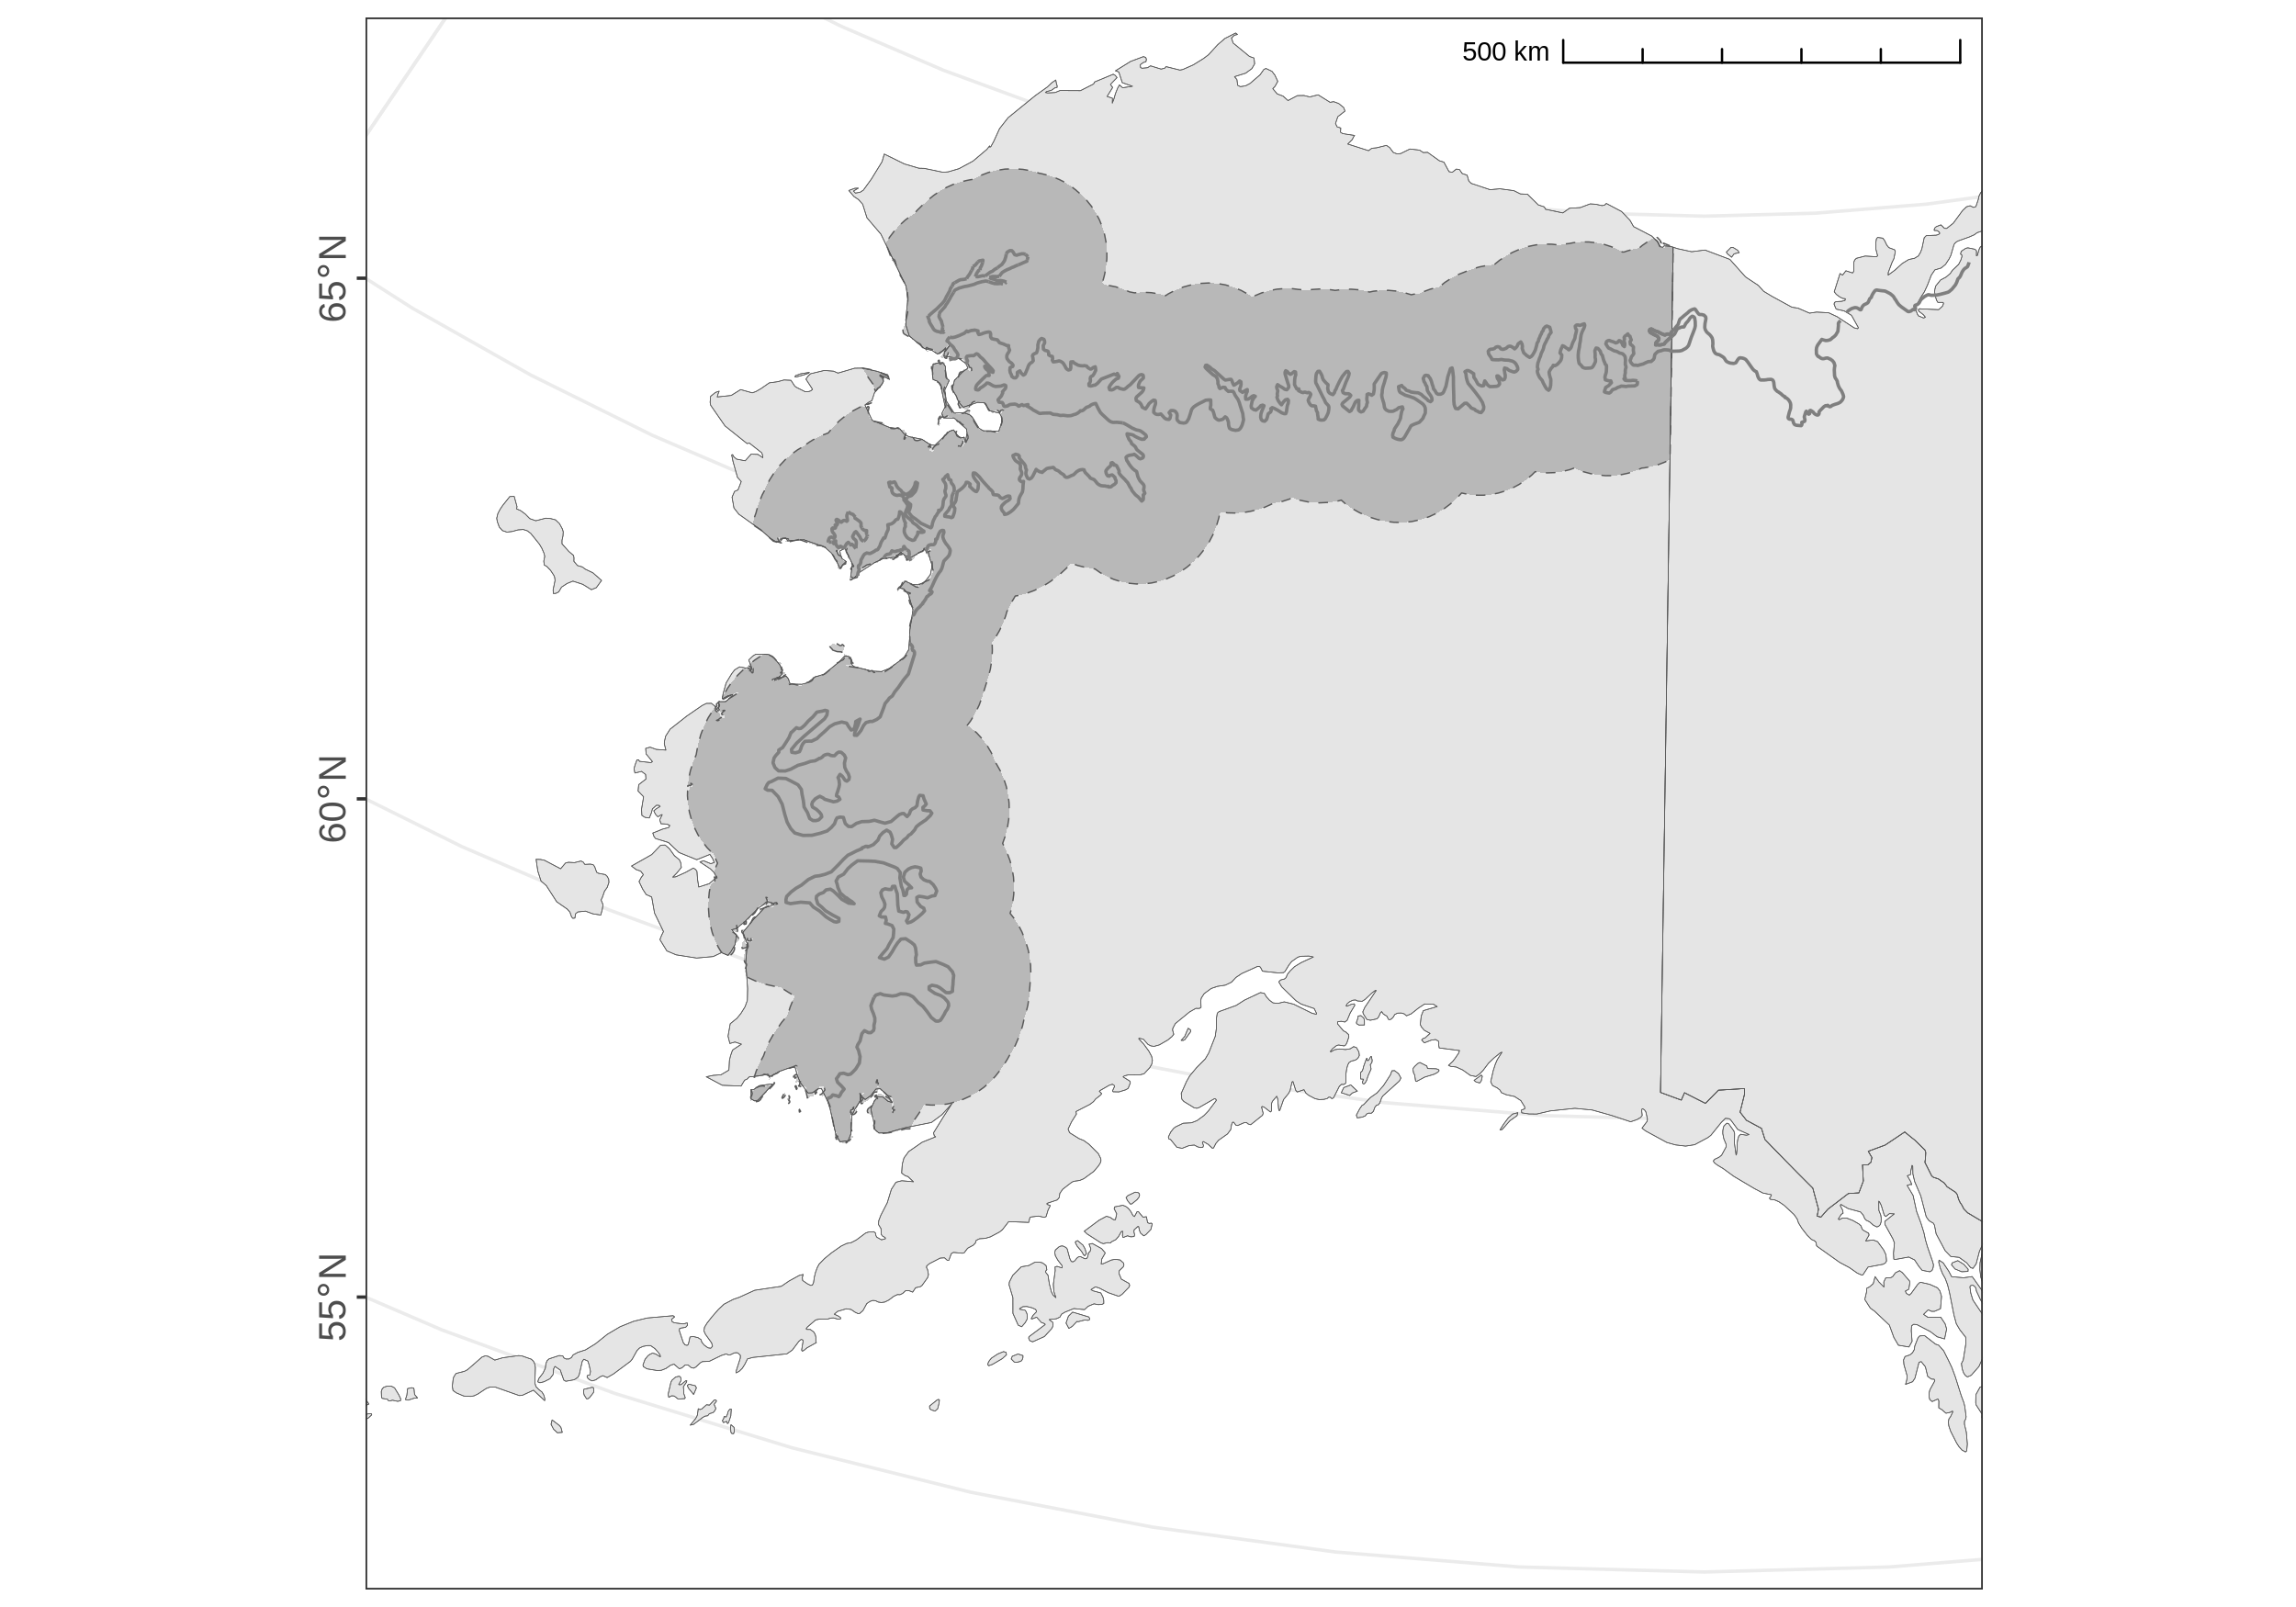

In [144]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 250, warn=-1)

map_list = list(
        annotation_scale(location = "tr", style="ticks")
        #, annotation_north_arrow(location = "tl", which_north = "true", style=north_arrow_minimal())
        #geom_sf(data = above_domain, fill=NA, linetype = "dotted", linewidth=0.75)
    )

map_overview = do_map_above_boreal_modified(ABOVE_DOMAIN=FALSE) + 

        GET_CUSTOM_DINOv2_ALASKA_MAP(crs_canalb=crs_canalb) +
        geom_sf(data = CAVM_treeline_100km_buf, linetype = 'dashed', fill='gray20', stroke=2, alpha=.25) +
        geom_sf(data = CAVM_treeline, linetype = 'solid', stroke=3, color='gray50') +
        #geom_sf(data=footprints_sf_dm_10m %>% filter(month %in% c(7,8)), color='black', alpha=0) +
    
        # DINOv3 training chips
        #geom_sf(data=chm_footprints_sf, aes(color=`source`, fill=`source`), linewidth=0.5) +
    
        # details
        #scale_fill_brewer(palette = 'Set2', aesthetics = c("colour", "fill"), name='Vegetation height data source   ') + 
        scale_fill_viridis_d(option = 'plasma', aesthetics = c("colour", "fill"), name='Vegetation canopy height model source   ') + 
        map_list +
        coord_sf(xlim=disp_win_coord[,'X'], ylim=disp_win_coord[,'Y'], crs=crs_canalb, expand=FALSE) +
        theme(
        legend.position = c(0.65, 0.10),
        legend.box = "horizontal",  # "horizontal" or "vertical"
        legend.direction = "vertical"
        ) 
    
          # # Add the label
          # geom_sf_label(data = point_sf, 
          #               aes(label = name),
          #               nudge_x = 0.5,  # Adjust label position
          #               nudge_y = 0.5,
          #               size = 3.25,
          #               fontface = "bold.italic")

map_overview

## Raster mosaic of height from DINOv3

In [15]:
# raster_read_proj_convert <- function(fn, to_crs="EPSG:4326", BOREAL_MAP=TRUE, LYR=NA, COARSEN=TRUE, COARSEN_FACTOR=2){
    
#     if(COARSEN){
#         raster_proj = aggregate(rast(fn), fact = COARSEN_FACTOR, fun = mean, na.rm = TRUE)
#     }else{
#         raster_proj <- rast(fn)    
#         }
        
#     r <- project(raster_proj, to_crs , method='cubic' ) # near
    
#     # Convert raster to data frame
#     r_df <- as.data.frame(r, xy = TRUE)
    
#     if(!is.na(LYR)){
#         names(r_df) <- c('x','y', LYR)
#         }
#     return (r_df)
#     }

In [14]:
raster_read_proj_convert <- function(fn, to_crs="EPSG:4326", BOREAL_MAP=TRUE, 
                                     LYR=NA, COARSEN=TRUE, COARSEN_FACTOR=2){
    
    raster_orig <- rast(fn)
    
    # Fix the CRS
    orig_crs <- crs(raster_orig)
    if(grepl("ENGCRS", orig_crs) || grepl("Unknown engineering datum", orig_crs)){
        crs(raster_orig) <- "EPSG:3338"
    }
    
    if(COARSEN && COARSEN_FACTOR > 1){
        raster_coarse <- aggregate(raster_orig, 
                                   fact = COARSEN_FACTOR, 
                                   fun = median,
                                   na.rm = TRUE)
    } else {
        raster_coarse <- raster_orig
    }
    
    # Check if reprojection is actually needed
    # Your target CRS looks like Alaska Albers too
    target_crs_obj <- crs(to_crs)
    
    if(identical(crs(raster_coarse), target_crs_obj)){
        message("Source and target CRS are the same, skipping reprojection")
        r <- raster_coarse
    } else {
        r <- project(raster_coarse, to_crs, method = 'bilinear')
    }
    
    # Convert to data frame
    r_df <- as.data.frame(r, xy = TRUE, na.rm = FALSE)
    
    if(!is.na(LYR)){
        names(r_df) <- c('x', 'y', LYR)
    }
    
    return(r_df)
}

In [16]:
NAME_STEM = 'cavm100km_alaska_chm_002m'

MAINDIR = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs'
INDIR =          paste0(MAINDIR, '/chm/2026_chm/4.3.2.5')
DIR_PAPER_FIGS = paste0(MAINDIR, '/paper_figs')

### Choose a mosaic

In [17]:
# mosaics are here
INDIR

[1] "/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5"

In [99]:
# 8 yr window (essentially - a decadal mosaic - verify 
#'002m_mos_2018_212_deltayr8_months789_50m' <- a stretch - covers most area, but uses Sept data
#'002m_mos_2018_212_deltayr8_months78_50m'  <- most likely to use this - July/Aug only

# 5 yr window
#'002m_mos_2018_212_deltayr5_months78_10m',
#'002m_mos_2018_212_deltayr5_months78_50m'
#'002m_mos_2018_212_deltayr5_months78_75m'

#MOSAIC_SUBDIR = '002m_mos_2018_212_deltayr5_months78_50m'
MOSAIC_SUBDIR = '002m_mos_2018_212_deltayr8_months78_50m'

In [100]:
str_split(MOSAIC_SUBDIR,'_', simplify = TRUE)
target_yr  = str_split(MOSAIC_SUBDIR,'_', simplify = TRUE)[1, 3]
target_doy = str_split(MOSAIC_SUBDIR,'_', simplify = TRUE)[1, 4]
delta_yr   = str_split(MOSAIC_SUBDIR,'_', simplify = TRUE)[1, 5]
months     = str_split(MOSAIC_SUBDIR,'_', simplify = TRUE)[1, 6]

002m,mos,2018,212,deltayr8,months78,50m


In [101]:
# Extract number, pad it, paste back
num <- str_extract(delta_yr, '\\d+')
num_padded <- str_pad(num, width = 2, pad = '0')
delta_yr_padded <- str_replace(delta_yr, '\\d+', num_padded)
delta_yr_padded

[1] "deltayr08"

In [102]:
r_df = raster_read_proj_convert(paste0(INDIR, "/",MOSAIC_SUBDIR,"/mosaic_",target_yr,"_DOY",target_doy,"_",delta_yr_padded,"_",months,".vrt")
                                , COARSEN=TRUE
                                ,to_crs=crs_canalb, BOREAL_MAP=FALSE, LYR='class') 

In [103]:
names(r_df) <- c('x','y','height','year','doy','mask_value')

#### Get area summary table and join to map colors consistently

In [104]:
area_summary = read.csv(paste0(DIR_PAPER_FIGS, "/", NAME_STEM, "_height_class_area_summary_",MOSAIC_SUBDIR,".csv"))
head(area_summary,10)

,height_class_combined,height_lower_combined,total,ci_lower,ci_upper,ci_half_width,total_formatted,ci_formatted,height_for_color
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,0-0.35m,0.00,140126.772,112895.966,169126.962,28115.498,"140,127","±28,115",0.00
2,0.35-1.0m,0.35,26353.380,21007.825,32558.289,5775.232,"26,353","± 5,775",0.35
3,1.0-1.5m,1.00,13946.495,10719.905,17520.233,3400.164,"13,946","± 3,400",1.00
4,1.5-3.0m,1.50,24091.388,17814.204,30234.210,6210.003,"24,091","± 6,210",1.50
5,3.0-4.0m,3.00,6777.640,4855.485,8996.348,2070.431,"6,778","± 2,070",3.00
6,4.0-5.0m,4.00,3920.900,2615.011,5551.580,1468.284,"3,921","± 1,468",4.00
7,>5m,5.00,5759.665,3708.173,8444.622,2368.225,"5,760","± 2,368",5.00


In [105]:
r_df_subset = r_df %>% filter(mask_value == 0)

In [106]:
# Sort area_summary
area_summary <- area_summary %>% arrange(height_lower_combined)

# Get breaks from lower bounds
breaks <- c(area_summary$height_lower_combined, Inf)

# Classify raster data

SCALE_FACTOR = 0.1 # dont forget to scale the raster values

r_df_subset <- r_df_subset %>%
  mutate(
    height_class = cut(height * SCALE_FACTOR, 
                      breaks = breaks,
                      labels = area_summary$height_class_combined,
                      right = FALSE,
                      include.lowest = TRUE)
  ) %>%
  # Add height_for_color by joining
  left_join(
    area_summary %>% select(height_class_combined, height_for_color),
    by = c("height_class" = "height_class_combined")
  )

In [107]:
names(r_df_subset)[3]

[1] "height"

### Mapped raster mosaic

In [108]:
# # Create labels from area_summary
# bin_labels <- area_summary %>%
#   arrange(height_lower_combined) %>%
#   pull(height_class_combined)

bin_breaks <- area_summary %>%
  arrange(height_lower_combined) %>%
  pull(height_lower_combined)

# Labels AT the breaks (not for the bins between)
bin_labels <- c('0', '0.35', '1.0', '1.5', '3.0', '4.0', '5.0')

In [109]:
bin_breaks

[1] 0.00 0.35 1.00 1.50 3.00 4.00 5.00

In [110]:
bin_labels

[1] "0"    "0.35" "1.0"  "1.5"  "3.0"  "4.0"  "5.0"

In [111]:
# # Actually, simpler approach - get all lower bounds plus one upper bound
# bin_breaks <- c(area_summary$height_lower_combined, max(area_summary$height_lower_combined) + 50)
# bin_breaks <- sort(unique(bin_breaks))
bin_breaks

[1] 0.00 0.35 1.00 1.50 3.00 4.00 5.00

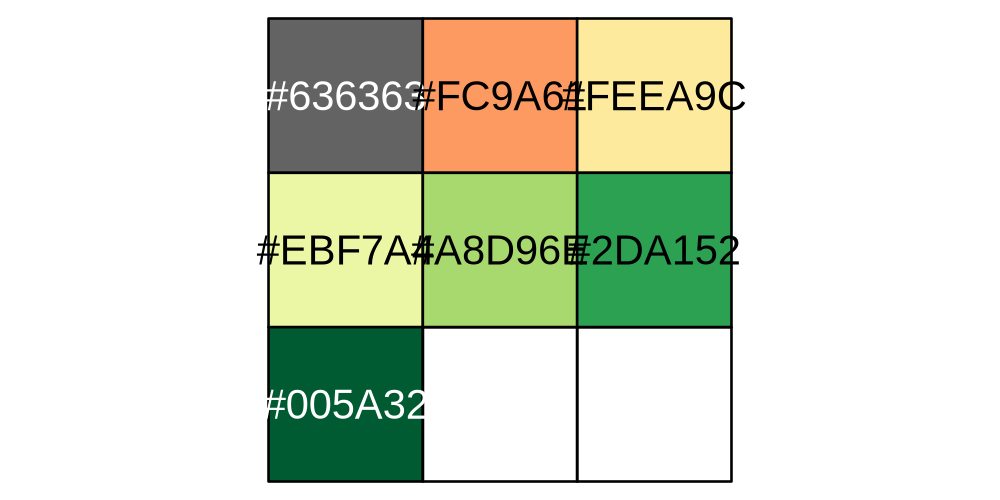

In [112]:
library(grDevices)

# Create 12 evenly spaced colors from your palette
forest_ht_colors <- c('#636363','#fc8d59','#fee08b','#ffffbf',
                      '#d9ef8b','#91cf60','#1a9850','#005a32')

forest_ht_colors_custom <- colorRampPalette(forest_ht_colors)(length(bin_labels))

# View them
options(repr.plot.width = 4, repr.plot.height =2, repr.plot.res = 250, warn=-1)

library(scales)
show_col(forest_ht_colors_custom)

In [113]:
# Classify data into bins first
r_df_subset <- r_df_subset %>%
  mutate(
    height_bin = cut(height_for_color,
                    breaks = c(0, 0.35, 1, 1.5, 3, 4, 5, Inf),
                    labels = c('0-0.35m', '0.35-1.0m', '1.0-1.5m', 
                              '1.5-3.0m', '3.0-4.0m', '4.0-5.0m', '>5m'),
                    right = FALSE,
                    include.lowest = TRUE)
  )

In [175]:
# Create annotation dataframe in lat/lon
inset_anno_geom_df <- data.frame(
  lon = c(-155.25, -137.5),
  lat = c(65.2, 68),
  label = c("100 km buffer\nof CAVM treeline", "CAVM treeline")
)

# Convert to sf object with WGS84 (EPSG:4326)
inset_anno_geom_sf <- st_as_sf(inset_anno_geom_df, coords = c("lon", "lat"), crs = 4326) %>% st_transform(crs = crs_canalb)

# Extract coordinates in projected CRS for ggplot
anno_coords <- st_coordinates(inset_anno_geom_sf)
inset_anno_geom_sf$x <- anno_coords[, "X"]
inset_anno_geom_sf$y <- anno_coords[, "Y"]

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


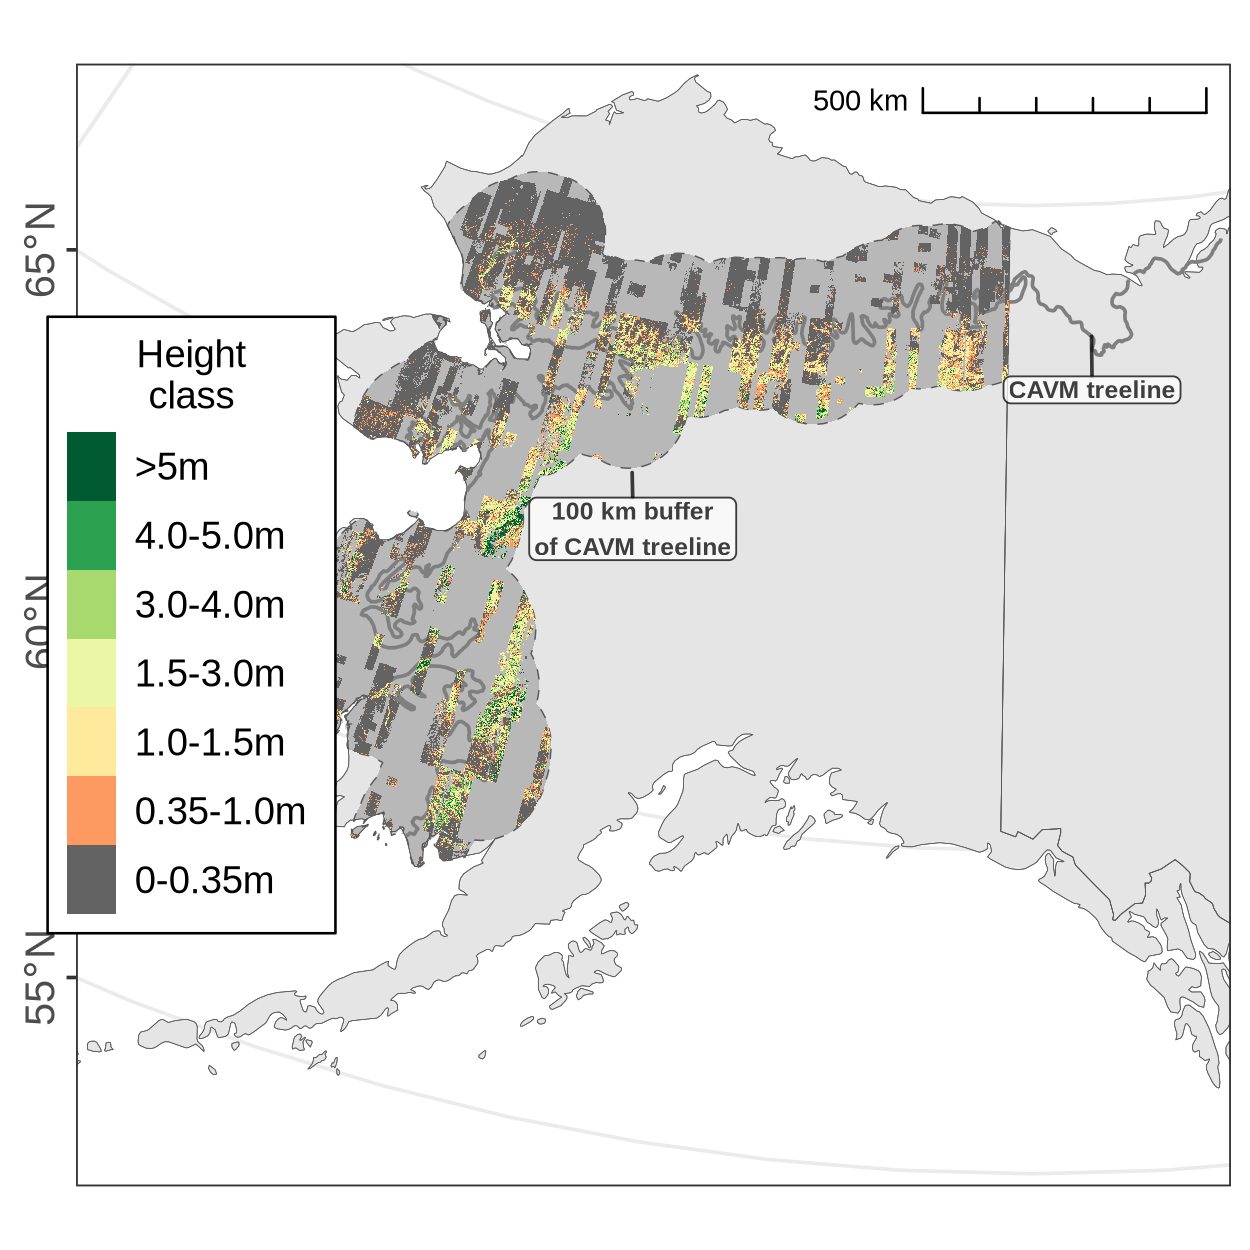

In [177]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 250, warn=-1)

# Build complete map
map <- map_overview +

    # Raster layer (bottom)
    geom_raster(data = r_df_subset, aes(x = x, y = y, fill = height_bin)) +
    
    geom_label_repel(data = inset_anno_geom_sf, 
                         aes(x = x, y = y, label = label), alpha=0.75,
                    hjust = 0.5, vjust = 0.5, 
                    fill = "white", 
                    nudge_x = 1000,      # Offset to the right (adjust for your CRS units)
                    nudge_y = -100000,      # Offset upward
                    size = 2.5, 
                    fontface = "bold",
                    fill = "white", 
                    alpha = 0.8,
                    box.padding = 0.5,
                    segment.color = "black",  # Line connecting label to point
                    segment.size = 0.5,
                    label.padding = unit(0.1, "lines")) +
    scale_fill_manual(
    values = forest_ht_colors_custom,  # Select 7 colors for 7 bins
    name = "Height\nclass",
    na.value = "transparent",
    guide = guide_legend(
      keywidth = unit(0.5, "cm"),
      keyheight = unit(0.7, "cm"),
      title.position = "top",
      title.hjust = 0.5,
      ncol = 1
    )
    ) +
    guides(fill = guide_legend(
    keywidth = unit(0.5, "cm"),
    keyheight = unit(0.7, "cm"),
    title.position = "top",
    title.hjust = 0.5,
    reverse = TRUE
    )) +
    theme(
        legend.position = c(0.1, 0.50),
        # legend.box = "horizontal",  # "horizontal" or "vertical"
        # legend.direction = "vertical"
        ) 

print(map)

In [178]:
DIR_PAPER_FIGS
NAME_STEM
MOSAIC_SUBDIR

[1] "/explore/nobackup/projects/above/misc/ABoVE_Shrubs/paper_figs"

[1] "cavm100km_alaska_chm_002m"

[1] "002m_mos_2018_212_deltayr8_months78_50m"

In [179]:
p_bar   = readRDS(paste0(DIR_PAPER_FIGS, "/p_bar_",   NAME_STEM, "_height_class_area_with_ci_",MOSAIC_SUBDIR,".rds"))
p_donut = readRDS(paste0(DIR_PAPER_FIGS, "/p_donut_", NAME_STEM, "_height_class_area_with_ci_",MOSAIC_SUBDIR,".rds"))

In [180]:
p_bar$labels$subtitle

[1] "From 900 commercial VHR acquisitions covering 220,976 km² of 100 km buffer of treeline"

In [181]:
area_stats <- fread(paste0(DIR_PAPER_FIGS,'/', NAME_STEM, '_height_class_area_',MOSAIC_SUBDIR,'.csv'))

In [182]:
mosaic_smry <- fread(list.files(paste0(INDIR,'/',MOSAIC_SUBDIR,'/'), 
                            pattern = 'mosaic_summary_.*\\.csv$', 
                            full.names = TRUE)[1])

# Calculate total valid area
total_area_km2 <- sum(area_stats$total_valid_area_km2)
total_area_aoi_km2 = sum(area_stats$total_area_aoi_km2)
pct_AOI_mapped = round(100 * (sum(area_stats$total_valid_area_km2) / sum(area_stats$total_area_aoi_km2)), 1)
n_files <- nrow(area_stats)

In [183]:
dim(area_stats)

[1] 103  25

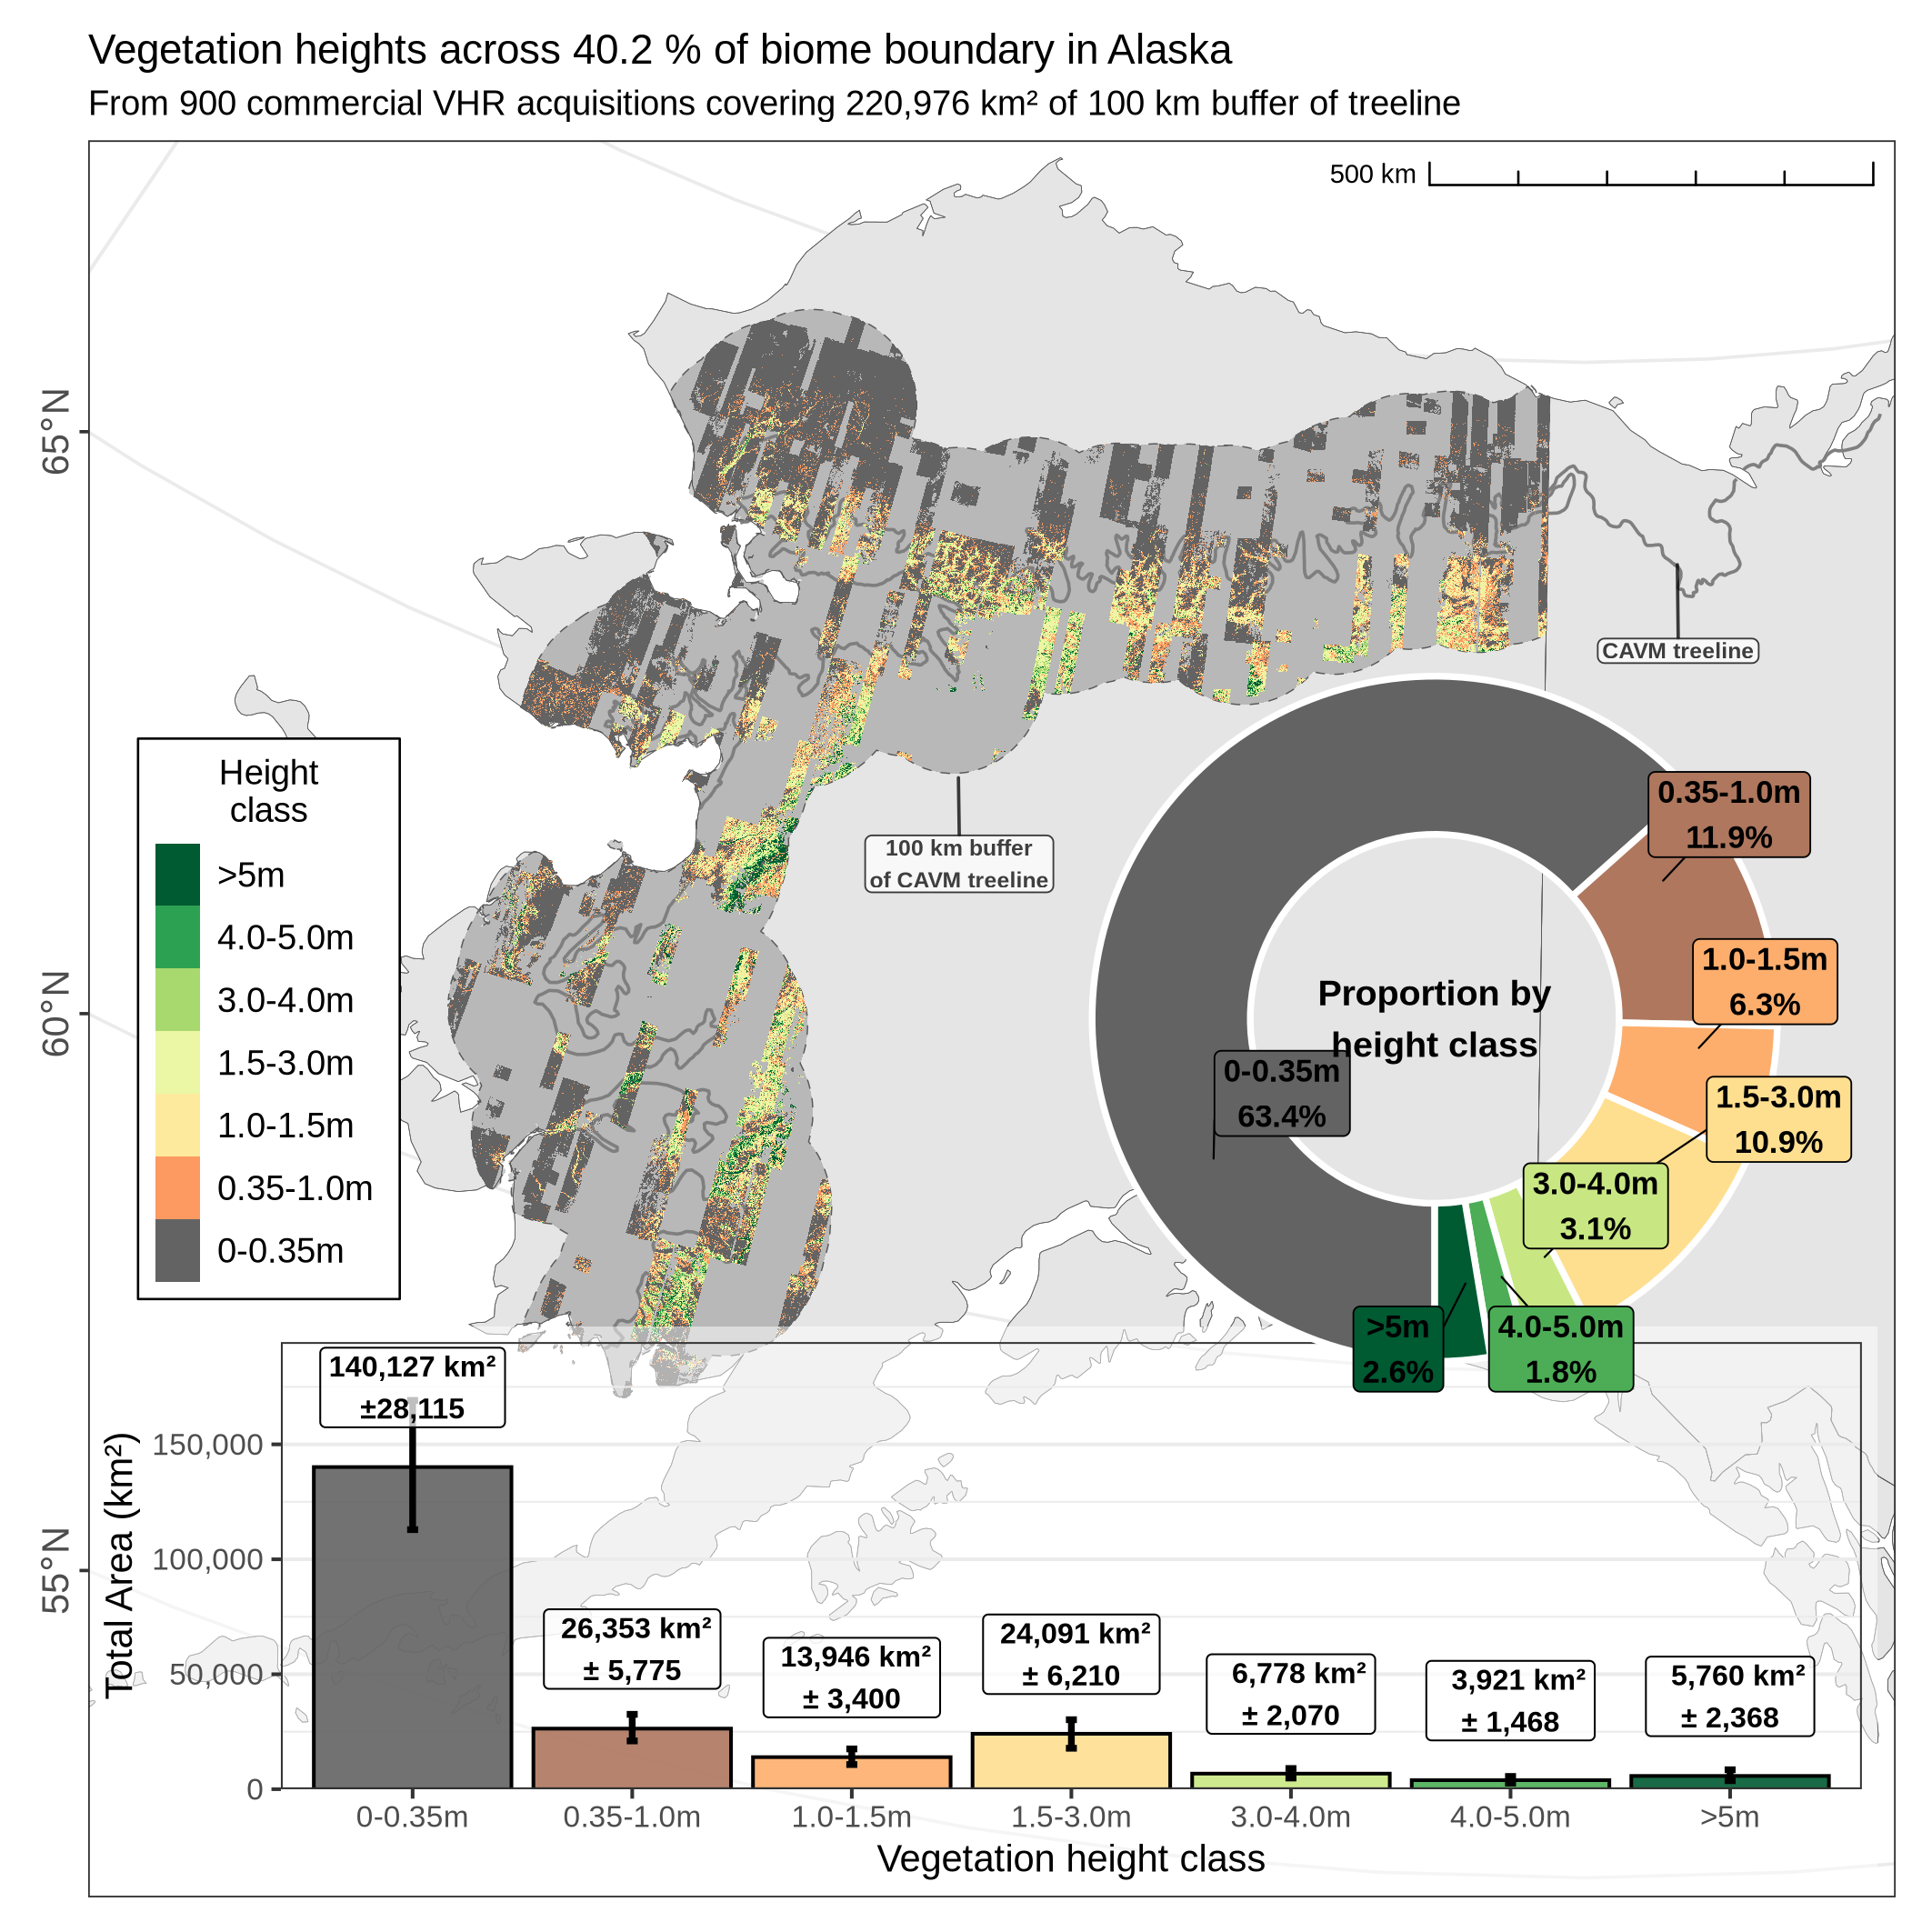

In [184]:
options(repr.plot.width = 8.5, repr.plot.height = 8.5, repr.plot.res = 250, warn=-1)

# Create the combined plot with p_bar and p_donut inset

# Extract title and subtitle from p_donut
p_title <- p_bar$labels$title
p_subtitle <- p_bar$labels$subtitle

combined_plot <- 
    (map + labs(
        title = p_title,
        subtitle = p_subtitle
      )
     ) +
  # For p_bar
  inset_element(
        p_bar + 
          labs(title=NULL, subtitle=NULL, caption=NULL) + 
          theme(
                text = element_text(size = 12),
                #plot.background = element_blank(),    # Fully transparent
                plot.background = element_rect(fill = scales::alpha("white", 0.5), color = NA),
                panel.background = element_blank(),   # Fully transparent
                plot.margin = margin(5, 5, 5, 5)
                ), 
        #left = 0.5, bottom = 0.05, right = 0.05, top = 0.5,
        left = 0.001, bottom = 0.001, right = 0.99, top = 0.325,
        align_to = "panel"
        ) +
  # For p_donut
  inset_element(
        p_donut,
        #left = 0.5, bottom = 0.05, right = 0.05, top = 0.5,
        , left = 0.5, bottom = 0.25, right = 0.99, top = 0.75,
        align_to = "panel"
        ) 


print(combined_plot)

In [186]:
# Save 'combined_plot' plot
ggsave(paste0(DIR_PAPER_FIGS, "/map_bar_donut_", NAME_STEM, "_height_class_area_with_ci_",MOSAIC_SUBDIR,".png"), combined_plot, width = 9, height = 9, dpi = 300)